In [1]:
import numpy as np
import librosa
import soundfile as sf

config = {
            'noise_estimation_method': 'vad_based',  # Ph∆∞∆°ng ph√°p ∆∞·ªõc t√≠nh nhi·ªÖu
            'smoothing_constant': 0.98,              # H·∫±ng s·ªë l√†m m·ªãn
            'min_gain': 0.1,                         # Gain t·ªëi thi·ªÉu
            'max_gain': 3.0,                         # Gain t·ªëi ƒëa
            'frequency_smoothing': 2 ,                # L√†m m·ªãn t·∫ßn s·ªë
            'snr_floor_db': -20                      # S√†n SNR (dB)
        }
y, sr = librosa.load("20250723_162029_02_dsp_spectral_subtracted.wav", sr=None)
D_full = librosa.stft(y)
D_vocals, D_crowd = librosa.decompose.hpss(D_full, margin=1.0)
magnitude = np.abs(D_full)
phase = np.angle(D_full)
signal_psd = magnitude**2
noise_psd = np.mean(np.abs(D_crowd)**2, axis=1, keepdims=True)
smoothing_constant = config['smoothing_constant']
smoothed = np.zeros_like(noise_psd)
smoothed[:, 0] = noise_psd[:, 0]
        
for i in range(1, noise_psd.shape[1]):
    smoothed[:, i] = smoothing_constant * smoothed[:, i-1] + \
(1 - smoothing_constant) * noise_psd[:, i]
snr_linear = signal_psd / (smoothed + 1e-10)
snr_db = 10 * np.log10(snr_linear)
snr_db = np.maximum(snr_db, config['snr_floor_db'])
snr_linear = 10**(snr_db / 10)
wiener_gain = snr_linear / (snr_linear + 1)
wiener_gain = np.clip(wiener_gain, config['min_gain'], config['max_gain'])
smoothed_gain = np.zeros_like(wiener_gain)
        
for i in range(wiener_gain.shape[1]):
    frame = wiener_gain[:, i]
    kernel = np.ones(config['frequency_smoothing']) / config['frequency_smoothing']
    smoothed_gain[:, i] = np.convolve(frame, kernel, mode='same')
# √Åp d·ª•ng b·ªô l·ªçc
filtered_magnitude = magnitude * smoothed_gain   
filtered_magnitude = filtered_magnitude * np.exp(1j * phase)
final = librosa.istft(filtered_magnitude, length=len(y))
sf.write("filter.wav", final, sr)

In [2]:
# get f0 track
f0_track = []
magnitude_filtered = np.abs(filtered_magnitude)
# X·ª≠ l√Ω t·ª´ng frame
for frame_idx in range(magnitude_filtered.shape[1]):
    frame = magnitude_filtered[:, frame_idx]
            
    # Ph∆∞∆°ng ph√°p autocorrelation
    autocorr = np.correlate(frame, frame, mode='full')
    autocorr = autocorr[len(autocorr)//2:]  # L·∫•y ph·∫ßn d∆∞∆°ng
            
    # T√¨m peak (b·ªè qua DC component)
    min_period = int(sr / 1000)  # T·∫ßn s·ªë t·ªëi ƒëa 1000 Hz
    max_period = int(sr / 80)    # T·∫ßn s·ªë t·ªëi thi·ªÉu 80 Hz
            
    if len(autocorr) > max_period:
        # T√¨m peak trong kho·∫£ng h·ª£p l·ªá
        peak_idx = np.argmax(autocorr[min_period:max_period]) + min_period
        f0 = sr / peak_idx if peak_idx > 0 else 0
    else:
        f0 = 0
            
    f0_track.append(f0)
        
f0_track = np.array(f0_track)

In [17]:
# Harmonic enhancement
config = {
    'harmonics_count': 8,  # S·ªë l∆∞·ª£ng √¢m h√†i c·∫ßn x·ª≠ l√Ω
    'harmonic_threshold': 0.4,  # Ng∆∞·ª°ng c∆∞·ªùng ƒë·ªô √¢m h√†i
    'enhancement_factor': 4,  # H·ªá s·ªë tƒÉng c∆∞·ªùng
}

n_fft = (D_full.shape[0] - 1) * 2

def calculate_harmonic_strength(magnitude_frame, bin_idx, window_size=3):
        start_idx = max(0, bin_idx - window_size)
        end_idx = min(len(magnitude_frame), bin_idx + window_size + 1)
        
        local_region = magnitude_frame[start_idx:end_idx]
        peak_value = magnitude_frame[bin_idx]
        
        # C∆∞·ªùng ƒë·ªô √¢m h√†i = peak / (trung b√¨nh xung quanh)
        surrounding_mean = (np.sum(local_region) - peak_value) / (len(local_region) - 1)
        
        return peak_value / (surrounding_mean + 1e-10)
stft_matrix = filtered_magnitude
magnitude = np.abs(stft_matrix)
phase = np.angle(stft_matrix)
        
# T·∫°o b·∫£n sao ƒë·ªÉ s·ª≠a ƒë·ªïi
enhanced_magnitude = magnitude.copy()
        
# X·ª≠ l√Ω t·ª´ng frame
for frame_idx in range(magnitude.shape[1]):
    f0 = f0_track[frame_idx]
            
    if f0 > 0:  # N·∫øu ph√°t hi·ªán ƒë∆∞·ª£c F0 h·ª£p l·ªá
        # T√≠nh to√°n v·ªã tr√≠ c√°c √¢m h√†i
        harmonics = [f0 * (i + 1) for i in range(config['harmonics_count'])]
                
        # T√¨m bin t·∫ßn s·ªë cho t·ª´ng √¢m h√†i
        for harmonic_freq in harmonics:
            if harmonic_freq < sr / 2:  # Trong d·∫£i Nyquist
                # T√¨m bin t·∫ßn s·ªë g·∫ßn nh·∫•t
                bin_idx = int(harmonic_freq * n_fft / sr)
                        
                if bin_idx < len(magnitude):
                # T√≠nh c∆∞·ªùng ƒë·ªô √¢m h√†i
                    harmonic_strength = calculate_harmonic_strength(
                        magnitude[:, frame_idx], bin_idx, window_size=3
                    )
                            
                    # C·∫£i thi·ªán n·∫øu tr√™n ng∆∞·ª°ng
                    if harmonic_strength > config['harmonic_threshold']:
                        enhanced_magnitude[bin_idx, frame_idx] *= config['enhancement_factor']
        
# T√°i t·∫°o STFT v·ªõi phase g·ªëc
enhanced_stft = enhanced_magnitude * np.exp(1j * phase)
harmonic_enhanced = librosa.istft(enhanced_stft, length=len(y))
sf.write("harmonic_enhanced.wav", harmonic_enhanced, sr)

In [9]:
config = {
    'rms_window_size': 1024,      # K√≠ch th∆∞·ªõc c·ª≠a s·ªï RMS
    'smoothing_factor': 0.95,      # H·ªá s·ªë l√†m m·ªãn
    'threshold_db': -35,          # Ng∆∞·ª°ng c·ªïng (dB) - **B·ªî SUNG**
    'attack_time_ms': 1,          # Th·ªùi gian attack (ms) - **B·ªî SUNG**
    'release_time_ms': 100,       # Th·ªùi gian release (ms) - **B·ªî SUNG**
    'hold_time_ms': 10 
}
audio = harmonic_enhanced
def calculate_rms_envelope(audio, window_size):
    hop_size = window_size // 4  # Ch·ªìng l·∫•p 75%
    rms_values = []
    # T√≠nh RMS cho t·ª´ng c·ª≠a s·ªï
    for i in range(0, len(audio) - window_size, hop_size):
        window = audio[i:i + window_size]
        rms = np.sqrt(np.mean(window**2))  # Root Mean Square
        rms_values.append(rms)
    # N·ªôi suy v·ªÅ ƒë·ªô d√†i g·ªëc
    if len(rms_values) > 0:
        rms_envelope = np.interp(
            np.arange(len(audio)),                          # ƒêi·ªÉm n·ªôi suy
            np.arange(0, len(audio), hop_size)[:len(rms_values)],  # ƒêi·ªÉm g·ªëc
            rms_values                                       # Gi√° tr·ªã RMS
        )
    else:
        rms_envelope = np.zeros(len(audio))
        
    return rms_envelope
def generate_gate_control(rms_db):
    # X√°c ƒë·ªãnh tr·∫°ng th√°i c·ªïng d·ª±a tr√™n ng∆∞·ª°ng
    gate_state = rms_db > config['threshold_db']
    # T√≠nh c√°c h·∫±ng s·ªë th·ªùi gian theo samples
    attack_samples = int(config['attack_time_ms'] * sr / 1000)
    release_samples = int(config['release_time_ms'] * sr / 1000)
    hold_samples = int(config['hold_time_ms'] * sr / 1000)
        
    # M√°y tr·∫°ng th√°i cho ƒëi·ªÅu khi·ªÉn c·ªïng
    gate_control = np.zeros_like(rms_db)
    current_state = 0  # 0: ƒë√≥ng, 1: ƒëang m·ªü, 2: m·ªü, 3: ƒëang ƒë√≥ng
    hold_counter = 0
    ramp_position = 0
    for i in range(len(rms_db)):
        if gate_state[i]:  # T√≠n hi·ªáu tr√™n ng∆∞·ª°ng
            if current_state == 0:  # B·∫Øt ƒë·∫ßu m·ªü c·ªïng
                current_state = 1
                ramp_position = 0
            elif current_state == 1:  # Ti·∫øp t·ª•c m·ªü c·ªïng
                ramp_position += 1
                if ramp_position >= attack_samples:
                    current_state = 2  # M·ªü ho√†n to√†n
            elif current_state == 3:  # D·ª´ng ƒë√≥ng c·ªïng
                current_state = 2
            hold_counter = hold_samples  # Reset hold counter
                
        else:  # T√≠n hi·ªáu d∆∞·ªõi ng∆∞·ª°ng
            if current_state == 2:  # B·∫Øt ƒë·∫ßu hold
                hold_counter -= 1
                if hold_counter <= 0:
                    current_state = 3  # B·∫Øt ƒë·∫ßu ƒë√≥ng c·ªïng
                    ramp_position = 0
            elif current_state == 3:  # Ti·∫øp t·ª•c ƒë√≥ng c·ªïng
                ramp_position += 1
                if ramp_position >= release_samples:
                    current_state = 0  # ƒê√≥ng ho√†n to√†n
            
        # T√≠nh gi√° tr·ªã c·ªïng
        if current_state == 0:  # ƒê√≥ng
            gate_control[i] = 0
        elif current_state == 1:  # ƒêang m·ªü
            gate_control[i] = ramp_position / attack_samples if attack_samples > 0 else 1
        elif current_state == 2:  # M·ªü
            gate_control[i] = 1
        elif current_state == 3:  # ƒêang ƒë√≥ng
            gate_control[i] = 1 - (ramp_position / release_samples) if release_samples > 0 else 0
        
    return gate_control
# T√≠nh envelope RMS
rms_envelope = calculate_rms_envelope(harmonic_enhanced, config['rms_window_size'])
# Chuy·ªÉn ƒë·ªïi sang dB
rms_db = 20 * np.log10(rms_envelope + 1e-10)
# T·∫°o t√≠n hi·ªáu ƒëi·ªÅu khi·ªÉn c·ªïng
gate_control = generate_gate_control(rms_db)
# √Åp d·ª•ng c·ªïng v·ªõi l√†m m·ªãn
smoothing_factor = config['smoothing_factor']
smoothed_gate = np.zeros_like(gate_control)
smoothed_gate[0] = gate_control[0]
# L√†m m·ªãn t√≠n hi·ªáu ƒëi·ªÅu khi·ªÉn
for i in range(1, len(gate_control)):
    smoothed_gate[i] = smoothing_factor * smoothed_gate[i-1] + \
        (1 - smoothing_factor) * gate_control[i]
# √Åp d·ª•ng c·ªïng l√™n t√≠n hi·ªáu
gated_audio = audio * smoothed_gate
sf.write("gated_audio.wav", gated_audio, sr)

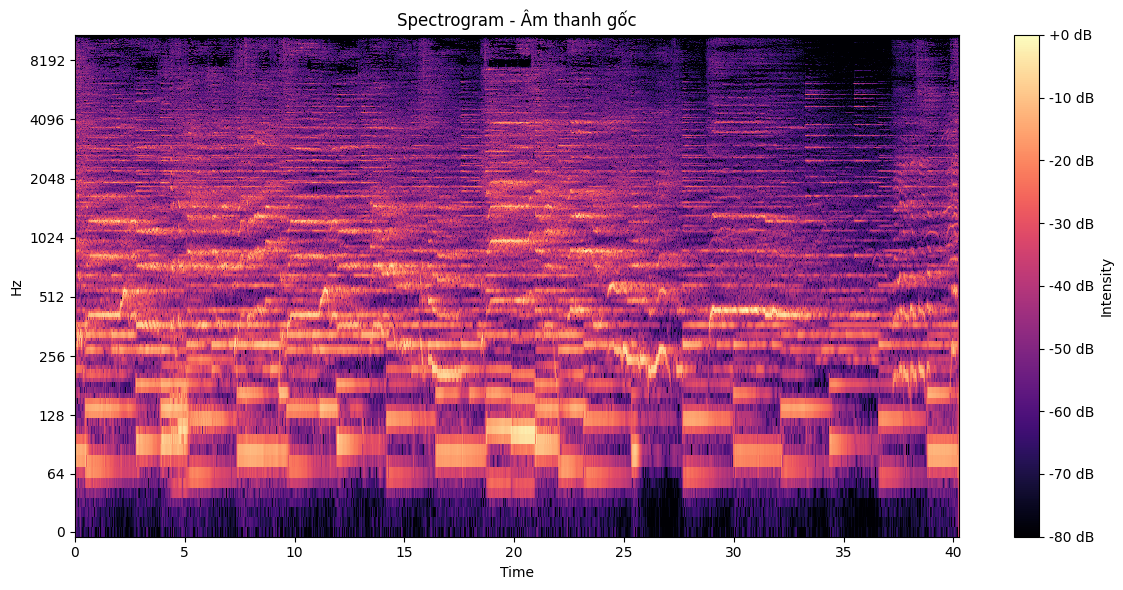

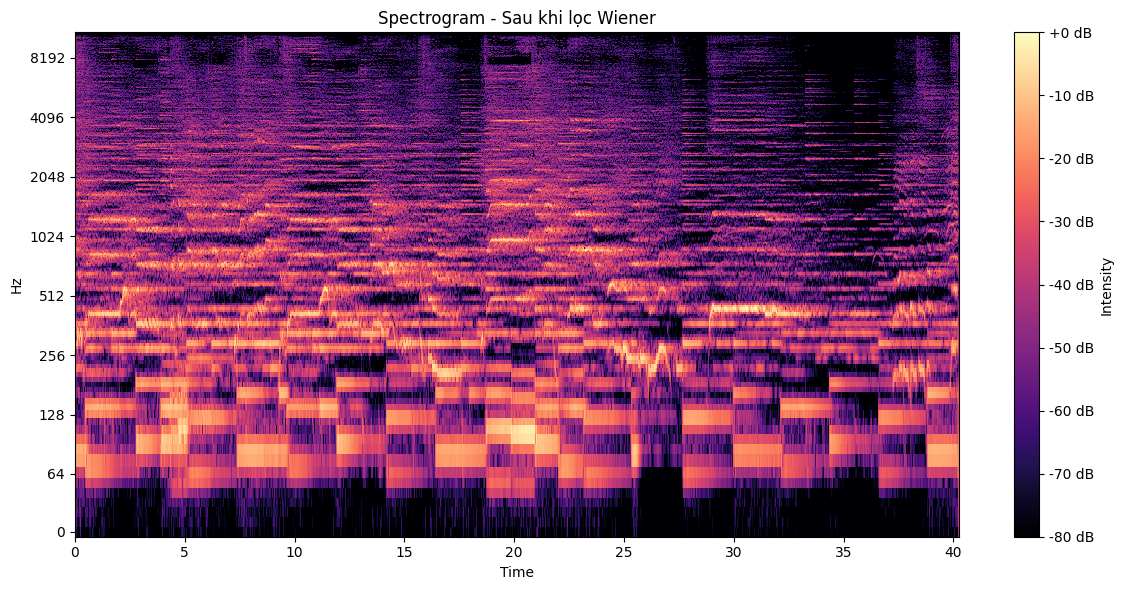

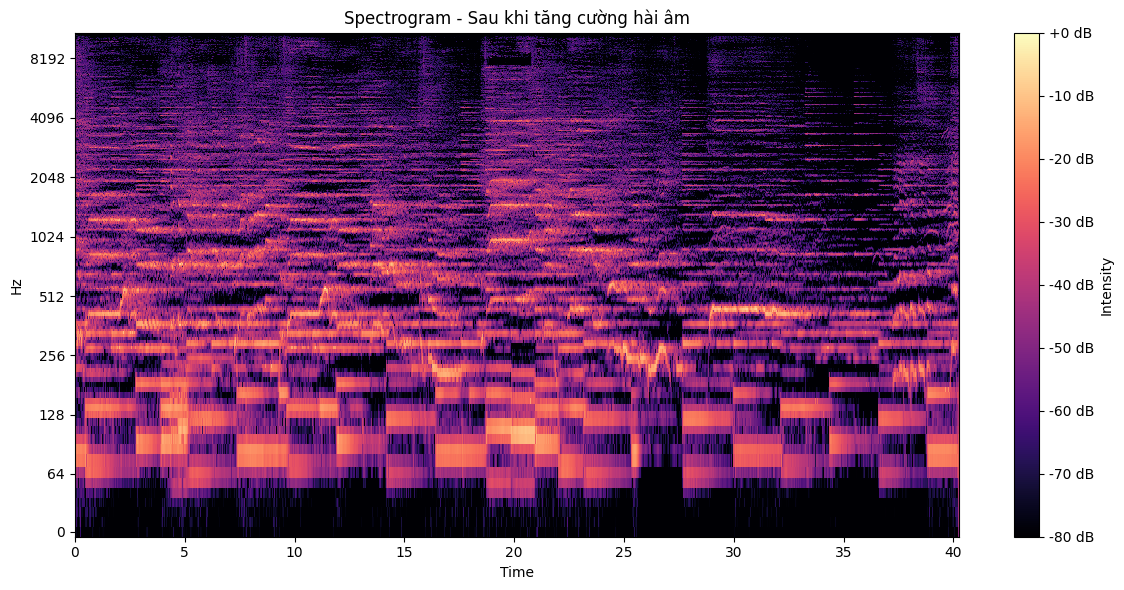

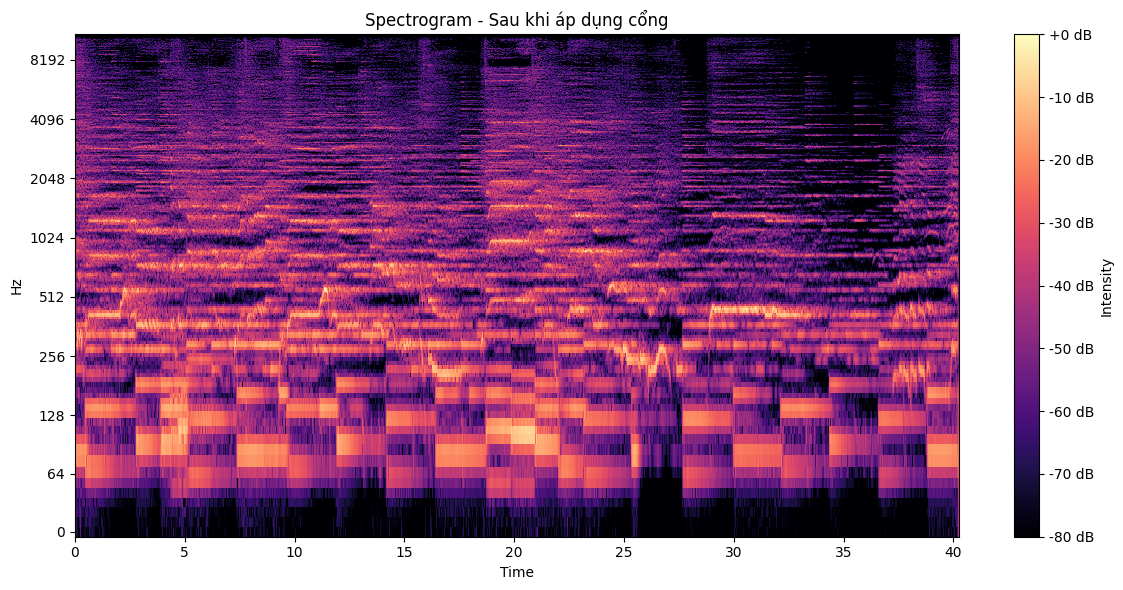

In [10]:
import matplotlib.pyplot as plt
import librosa.display


# H√†m ti·ªán √≠ch ƒë·ªÉ v·∫Ω spectrogram
def plot_spectrogram(stft_matrix, sr, title):
    """V·∫Ω bi·ªÉu ƒë·ªì spectrogram t·ª´ ma tr·∫≠n STFT ph·ª©c."""
    magnitude = np.abs(stft_matrix)
    db_magnitude = librosa.amplitude_to_db(magnitude, ref=np.max)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    img = librosa.display.specshow(db_magnitude, sr=sr, x_axis='time', y_axis='log', ax=ax)
    fig.colorbar(img, ax=ax, format='%+2.0f dB', label='Intensity')
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

# 1. Bi·ªÉu ƒë·ªì c·ªßa √¢m thanh ƒë·∫ßu v√†o (sau khi ƒë√£ qua spectral subtraction)
plot_spectrogram(D_full, sr, 'Spectrogram - √Çm thanh g·ªëc')

# 2. Bi·ªÉu ƒë·ªì sau khi qua b·ªô l·ªçc Wiener
plot_spectrogram(filtered_magnitude, sr, 'Spectrogram - Sau khi l·ªçc Wiener')

# 3. Bi·ªÉu ƒë·ªì sau khi tƒÉng c∆∞·ªùng h√†i √¢m
plot_spectrogram(enhanced_stft, sr, 'Spectrogram - Sau khi tƒÉng c∆∞·ªùng h√†i √¢m')
# 4. Bi·ªÉu ƒë·ªì sau khi √°p d·ª•ng c·ªïng
gated_stft = librosa.stft(gated_audio)
plot_spectrogram(gated_stft, sr, 'Spectrogram - Sau khi √°p d·ª•ng c·ªïng')

### Ph√¢n t√≠ch bi·ªÉu ƒë·ªì:

#    **Tr·ª•c ho√†nh (X):** Th·ªùi gian.
#    **Tr·ª•c tung (Y):** T·∫ßn s·ªë (t·ª´ th·∫•p ƒë·∫øn cao).
#    **M√†u s·∫Øc:** C∆∞·ªùng ƒë·ªô √¢m thanh. M√†u c√†ng "n√≥ng" (v√†ng, ƒë·ªè) th√¨ c∆∞·ªùng ƒë·ªô t·∫°i t·∫ßn s·ªë v√† th·ªùi ƒëi·ªÉm ƒë√≥ c√†ng l·ªõn.

# Khi nh√¨n v√†o c√°c bi·ªÉu ƒë·ªì, h√£y ch√∫ √Ω:
# 1.  **Trong bi·ªÉu ƒë·ªì "√Çm thanh g·ªëc"**: T√¨m c√°c d·∫£i t·∫ßn s·ªë c√≥ m√†u s·∫Øc s√°ng, li√™n t·ª•c theo chi·ªÅu ngang. ƒê√¢y th∆∞·ªùng l√† nhi·ªÖu n·ªÅn (ti·∫øng h√≤ h√©t, ti·∫øng √π).
# 2.  **Trong bi·ªÉu ƒë·ªì "Sau khi l·ªçc Wiener"**: So s√°nh v·ªõi bi·ªÉu ƒë·ªì g·ªëc. C√°c d·∫£i nhi·ªÖu n·ªÅn ƒë√≥ ph·∫£i m·ªù ƒëi ƒë√°ng k·ªÉ (m√†u chuy·ªÉn sang xanh, t√≠m). C√°c ƒë∆∞·ªùng n√©t ƒë·ª©t qu√£ng, thay ƒë·ªïi theo th·ªùi gian (gi·ªçng h√°t) n√™n ƒë∆∞·ª£c gi·ªØ l·∫°i.
# 3.  **Trong bi·ªÉu ƒë·ªì "Sau khi tƒÉng c∆∞·ªùng h√†i √¢m"**: So s√°nh v·ªõi bi·ªÉu ƒë·ªì th·ª© hai. B·∫°n s·∫Ω th·∫•y c√°c ƒë∆∞·ªùng n√©t c·ªßa gi·ªçng h√°t tr·ªü n√™n r√µ r√†ng v√† "d√†y" h∆°n m·ªôt ch√∫t do c√°c h√†i √¢m ƒë∆∞·ª£c khu·∫øch ƒë·∫°i.// filepath: d:\DSP-present\fancam_noise_reduction\test_config.ipynb


üìä WAVEFORM ANALYSIS FOR ALL PROCESSING STEPS
Step 1: Original (after spectral subtraction)
  RMS: 0.167909, Max: 0.949982, Length: 887296 samples
Step 2: After Wiener Filter
  RMS: 0.163880, Max: 0.942195, Length: 887296 samples
Step 3: After Harmonic Enhancement
  RMS: 0.169033, Max: 1.142572, Length: 887296 samples
Step 4: After Noise Gate
  RMS: 0.167741, Max: 1.050608, Length: 887296 samples


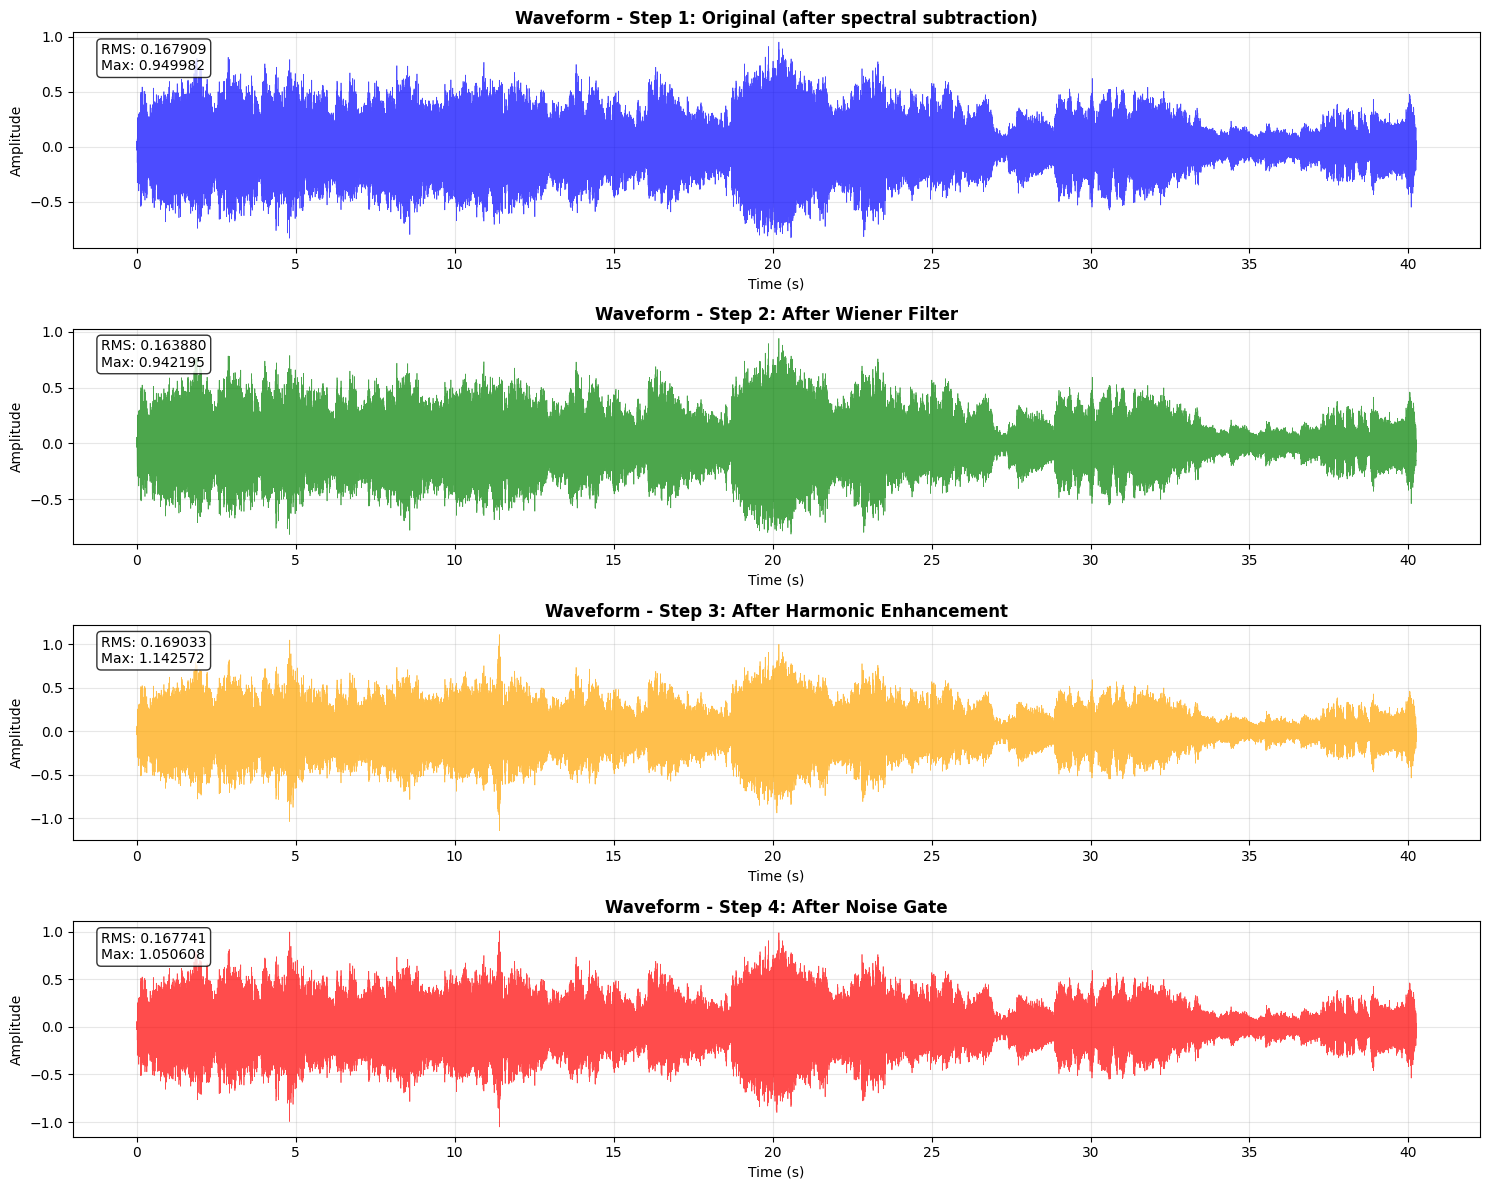


üìà OVERLAY COMPARISON:


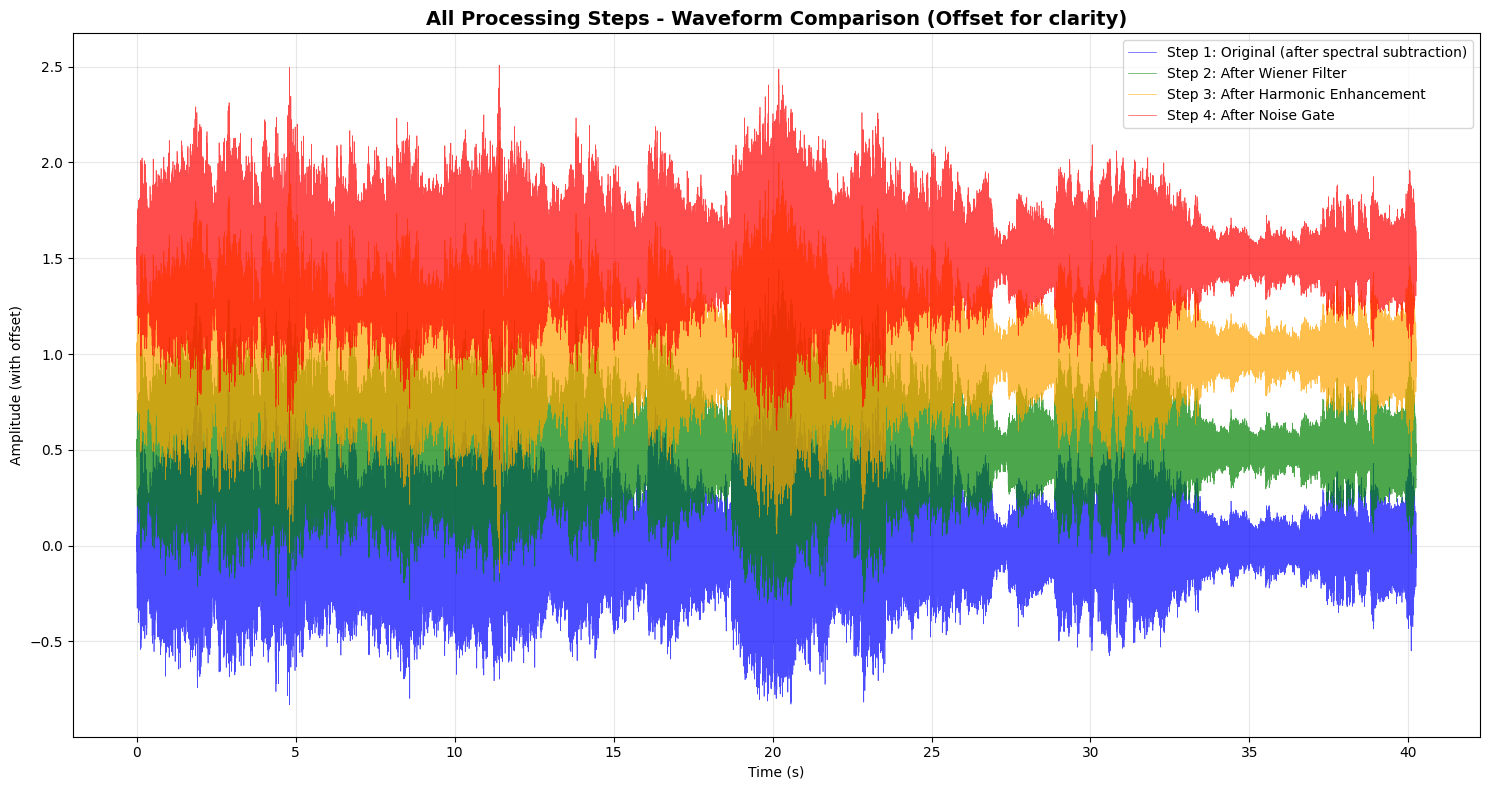

‚úì Waveform comparison plots saved successfully!


In [13]:
# Hi·ªÉn th·ªã waveform cho t·∫•t c·∫£ c√°c step
import matplotlib.pyplot as plt
import numpy as np

# T·∫≠p h·ª£p t·∫•t c·∫£ c√°c audio ƒë√£ x·ª≠ l√Ω
audio_files = {
    'Step 1: Original (after spectral subtraction)': y,
    'Step 2: After Wiener Filter': final,
    'Step 3: After Harmonic Enhancement': harmonic_enhanced,
    'Step 4: After Noise Gate': gated_audio
}

# T·∫°o figure v·ªõi subplots cho waveforms
fig, axes = plt.subplots(len(audio_files), 1, figsize=(15, 3*len(audio_files)))
if len(audio_files) == 1:
    axes = [axes]

colors = ['blue', 'green', 'orange', 'red']

print("üìä WAVEFORM ANALYSIS FOR ALL PROCESSING STEPS")
print("="*60)

# V·∫Ω waveform cho t·ª´ng step
for idx, (title, audio_data) in enumerate(audio_files.items()):
    # T·∫°o time axis
    time_axis = np.linspace(0, len(audio_data)/sr, len(audio_data))
    
    # V·∫Ω waveform
    axes[idx].plot(time_axis, audio_data, color=colors[idx], alpha=0.7, linewidth=0.5)
    axes[idx].set_title(f'Waveform - {title}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Time (s)')
    axes[idx].set_ylabel('Amplitude')
    axes[idx].grid(True, alpha=0.3)
    
    # Th√™m th√¥ng tin RMS v√† Max
    rms_val = np.sqrt(np.mean(audio_data**2))
    max_val = np.max(np.abs(audio_data))
    axes[idx].text(0.02, 0.95, f'RMS: {rms_val:.6f}\nMax: {max_val:.6f}', 
                   transform=axes[idx].transAxes, fontsize=10,
                   verticalalignment='top', 
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # In th·ªëng k√™
    print(f"{title}")
    print(f"  RMS: {rms_val:.6f}, Max: {max_val:.6f}, Length: {len(audio_data)} samples")

plt.tight_layout()
plt.savefig('all_waveforms_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# T·∫°o comparison plot - t·∫•t c·∫£ waveforms trong m·ªôt bi·ªÉu ƒë·ªì (v·ªõi offset)
plt.figure(figsize=(15, 8))

print("\nüìà OVERLAY COMPARISON:")
for idx, (title, audio_data) in enumerate(audio_files.items()):
    time_axis = np.linspace(0, len(audio_data)/sr, len(audio_data))
    # Offset ƒë·ªÉ tr√°nh ch·ªìng l·∫•p
    offset = idx * 0.5
    plt.plot(time_axis, audio_data + offset, color=colors[idx], alpha=0.7, 
             linewidth=0.5, label=title)

plt.title('All Processing Steps - Waveform Comparison (Offset for clarity)', fontsize=14, fontweight='bold')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (with offset)')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('waveforms_overlay_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("‚úì Waveform comparison plots saved successfully!")

In [ ]:
# Detailed waveform analysis v·ªõi zoom-in views
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

# Ch·ªçn m·ªôt ƒëo·∫°n ng·∫Øn ƒë·ªÉ zoom (3 gi√¢y ƒë·∫ßu)
zoom_samples = int(3 * sr)

for idx, (title, audio_data) in enumerate(audio_files.items()):
    if idx < 4:  # Ch·ªâ v·∫Ω 4 bi·ªÉu ƒë·ªì ƒë·∫ßu
        zoom_data = audio_data[:zoom_samples] if len(audio_data) >= zoom_samples else audio_data
        zoom_time_actual = np.linspace(0, len(zoom_data)/sr, len(zoom_data))
        
        axes[idx].plot(zoom_time_actual, zoom_data, color=colors[idx], linewidth=1)
        axes[idx].set_title(f'Zoom View (3s) - {title}', fontsize=10, fontweight='bold')
        axes[idx].set_xlabel('Time (s)')
        axes[idx].set_ylabel('Amplitude')
        axes[idx].grid(True, alpha=0.3)
        
        # Th√™m statistics
        rms_val = np.sqrt(np.mean(zoom_data**2))
        max_val = np.max(np.abs(zoom_data))
        std_val = np.std(zoom_data)
        axes[idx].text(0.02, 0.95, f'RMS: {rms_val:.6f}\nMax: {max_val:.6f}\nStd: {std_val:.6f}', 
                       transform=axes[idx].transAxes, fontsize=8,
                       verticalalignment='top',
                       bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('waveforms_zoom_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

# Statistics summary table
print("\n" + "="*80)
print("üìä WAVEFORM STATISTICS SUMMARY")
print("="*80)
print(f"{'Step':<35} {'RMS':<12} {'Max':<12} {'Min':<12} {'Std':<12} {'Length':<10}")
print("-"*80)

for title, audio_data in audio_files.items():
    rms_val = np.sqrt(np.mean(audio_data**2))
    max_val = np.max(audio_data)
    min_val = np.min(audio_data)
    std_val = np.std(audio_data)
    length = len(audio_data)
    
    print(f"{title:<35} {rms_val:<12.6f} {max_val:<12.6f} {min_val:<12.6f} {std_val:<12.6f} {length:<10}")

print("\nüìà PROCESSING IMPACT ANALYSIS:")
print("-"*50)

# So s√°nh gi·ªØa c√°c b∆∞·ªõc
original = audio_files['Step 1: Original (after spectral subtraction)']
wiener_filtered = audio_files['Step 2: After Wiener Filter']
harmonic_enhanced_audio = audio_files['Step 3: After Harmonic Enhancement']
noise_gated = audio_files['Step 4: After Noise Gate']

# T√≠nh % thay ƒë·ªïi RMS
original_rms = np.sqrt(np.mean(original**2))
wiener_rms = np.sqrt(np.mean(wiener_filtered**2))
harmonic_rms = np.sqrt(np.mean(harmonic_enhanced_audio**2))
gated_rms = np.sqrt(np.mean(noise_gated**2))

wiener_change = ((wiener_rms - original_rms) / original_rms) * 100
harmonic_change = ((harmonic_rms - wiener_rms) / wiener_rms) * 100
gated_change = ((gated_rms - harmonic_rms) / harmonic_rms) * 100

print(f"Wiener Filter:      {wiener_change:+6.2f}% RMS change")
print(f"Harmonic Enhance:   {harmonic_change:+6.2f}% RMS change")
print(f"Noise Gate:         {gated_change:+6.2f}% RMS change")
print(f"Overall Change:     {((gated_rms - original_rms) / original_rms) * 100:+6.2f}% RMS change")

# Energy analysis
print(f"\nüîã ENERGY ANALYSIS:")
print("-"*30)
original_energy = np.sum(original**2)
final_energy = np.sum(noise_gated**2)
energy_ratio = final_energy / original_energy

print(f"Original Energy:    {original_energy:.2e}")
print(f"Final Energy:       {final_energy:.2e}")
print(f"Energy Retained:    {energy_ratio:.3f} ({energy_ratio*100:.1f}%)")

if energy_ratio < 0.5:
    print("‚ö†Ô∏è  Warning: Significant energy loss - may indicate over-processing")
elif energy_ratio > 1.5:
    print("‚ö†Ô∏è  Warning: Energy gain detected - check for artifacts")
else:
    print("‚úÖ Energy levels within acceptable range")

print("\nüéµ Files exported:")
print("- all_waveforms_comparison.png")
print("- waveforms_overlay_comparison.png") 
print("- waveforms_zoom_analysis.png")